# End-to-end tutorial (OCSVM)
---
현대차 제공 OCSVM End to end 튜토리얼

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_preprocess import PreprocessData

from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Prepare Dataset

In [2]:
root_dir = '../datasets'
fname = 'pu_batt_sample10.csv'
dataset_dir = os.path.join(root_dir, fname)

In [3]:
ocsvm_dp = PreprocessData(dataset_dir, 'ocsvm')
ocsvm_scaled_vol_data, ocsvm_scaled_other_data = ocsvm_dp.preprocess_data()
print(ocsvm_scaled_vol_data.shape, ocsvm_scaled_other_data.shape)

(129663, 90) (129663, 9)


## Dimensionality Reduction

In [4]:
# %% 모델학습
# AE 전셀전압 차원축소
inputs = Input(shape=(ocsvm_scaled_vol_data.shape[1],))
encoded = Dense(64, activation='tanh', name="encode1")(inputs)
encoded = Dense(32, activation='tanh', name="encode2")(encoded)
encoded = Dense(10, activation='tanh', name="encode3")(encoded)
decoded = Dense(32, activation='tanh', name="decode1")(encoded)
decoded = Dense(64, activation='tanh', name="decode2")(decoded)
decoded = Dense(ocsvm_scaled_vol_data.shape[1], name="decode3")(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 encode1 (Dense)             (None, 64)                5824      
                                                                 
 encode2 (Dense)             (None, 32)                2080      
                                                                 
 encode3 (Dense)             (None, 10)                330       
                                                                 
 decode1 (Dense)             (None, 32)                352       
                                                                 
 decode2 (Dense)             (None, 64)                2112      
                                                                 
 decode3 (Dense)             (None, 90)                5850  

In [5]:
# %% Early stopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# AE 모델 컴파일 및 학습
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=optimizer, loss='mse')
history = autoencoder.fit(ocsvm_scaled_vol_data, ocsvm_scaled_vol_data, batch_size=32, epochs=3, validation_split=0.2,
                          callbacks=[early_stopping])  # Early stopping 콜백 추가

Epoch 1/3
3242/3242 [==============================] - 3s 1000us/step - loss: 0.0025 - val_loss: 7.3233e-04
Epoch 2/3
3242/3242 [==============================] - 3s 941us/step - loss: 4.2318e-05 - val_loss: 7.5866e-06
Epoch 3/3
3242/3242 [==============================] - 3s 943us/step - loss: 3.5060e-05 - val_loss: 7.9136e-05


In [6]:
for idx, layer in enumerate(autoencoder.layers):
    print(idx, layer.name, layer)

0 input_1 <keras.src.engine.input_layer.InputLayer object at 0x1273e8460>
1 encode1 <keras.src.layers.core.dense.Dense object at 0x146737160>
2 encode2 <keras.src.layers.core.dense.Dense object at 0x146737f70>
3 encode3 <keras.src.layers.core.dense.Dense object at 0x146737f10>
4 decode1 <keras.src.layers.core.dense.Dense object at 0x146825910>
5 decode2 <keras.src.layers.core.dense.Dense object at 0x146825e50>
6 decode3 <keras.src.layers.core.dense.Dense object at 0x1468250a0>


In [7]:
encoder_model = Model(autoencoder.layers[0].input, autoencoder.layers[3].output)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90)]              0         
                                                                 
 encode1 (Dense)             (None, 64)                5824      
                                                                 
 encode2 (Dense)             (None, 32)                2080      
                                                                 
 encode3 (Dense)             (None, 10)                330       
                                                                 
Total params: 8234 (32.16 KB)
Trainable params: 8234 (32.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
latent_vector = encoder_model.predict(ocsvm_scaled_vol_data)

4052/4052 [==============================] - 1s 331us/step


## Train OCSVM model

In [9]:
ocsvm_train_data = np.concatenate((ocsvm_scaled_other_data, latent_vector), axis=1)
ocsvm_train_data.shape

(129663, 19)

In [10]:
# OCSVM 학습
anomal_ratio = 0.0005
ocsvm_model = OneClassSVM(nu=anomal_ratio, kernel='rbf', gamma='auto')
ocsvm_model.fit(ocsvm_train_data)

OneClassSVM(gamma='auto', nu=0.0005)

## Plot Result

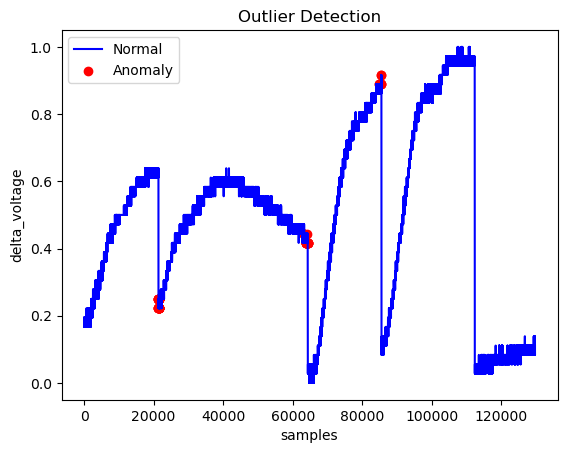

In [11]:
ocsvm_result = ocsvm_model.predict(ocsvm_train_data)
ocsvm_train_data = np.array(ocsvm_train_data)
plt.plot(range(len(ocsvm_train_data)), ocsvm_train_data[:, 8], color='b', label='Normal')
outliers = ocsvm_train_data[ocsvm_result == -1]
plt.scatter(np.where(ocsvm_result == -1)[0], outliers[:, 8], color='r', marker='o', label='Anomaly')
plt.xlabel('samples')
plt.ylabel('delta_voltage')
plt.title('Outlier Detection')
plt.legend()
plt.show()